In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [ ]:
df = pd.read_csv('creditcard.csv', encoding = 'latin1')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
df.shape

(284807, 31)

In [ ]:
df.isnull().values.any()

False

Distribution of fraudulent points: 0.17%


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


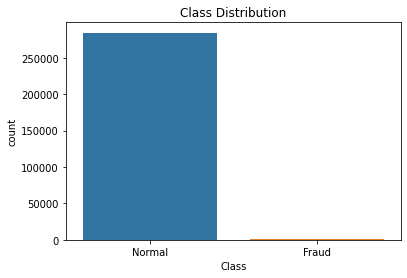

In [ ]:
print(("Distribution of fraudulent points: {:.2f}%".format(len(df[df['Class']==1])/len(df)*100)))
sns.countplot(df['Class'])
plt.title('Class Distribution')
plt.xticks(range(2),['Normal','Fraud'])
plt.show()


Class wise Analysis:


In [ ]:
normal = df[df['Class']==0]
fraud = df[df['Class']==1]
print("Normal datapoints: ", normal.shape[0])
print("Fraud datapoints: ", fraud.shape[0])

Normal datapoints:  284315
Fraud datapoints:  492


In [ ]:
normal['Amount'].describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [ ]:
fraud['Amount'].describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

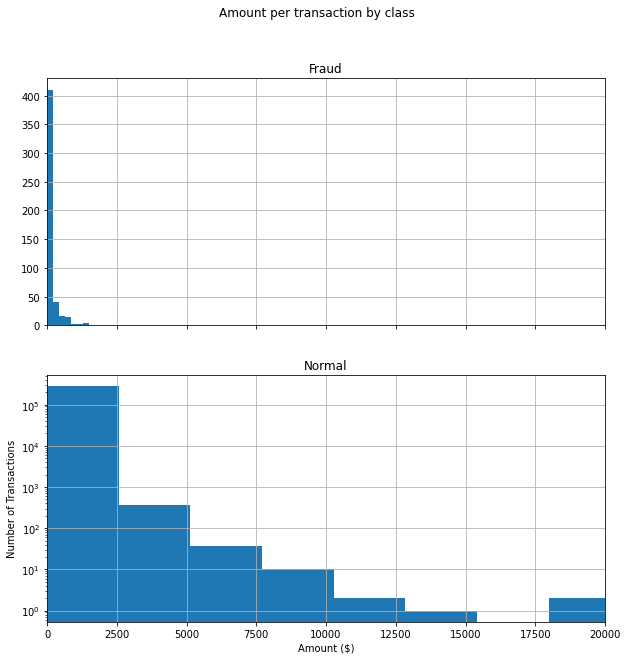

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize = (10,10) )
f.suptitle('Amount per transaction by class')

bins = 10

ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

ax1.grid()
ax2.grid()
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

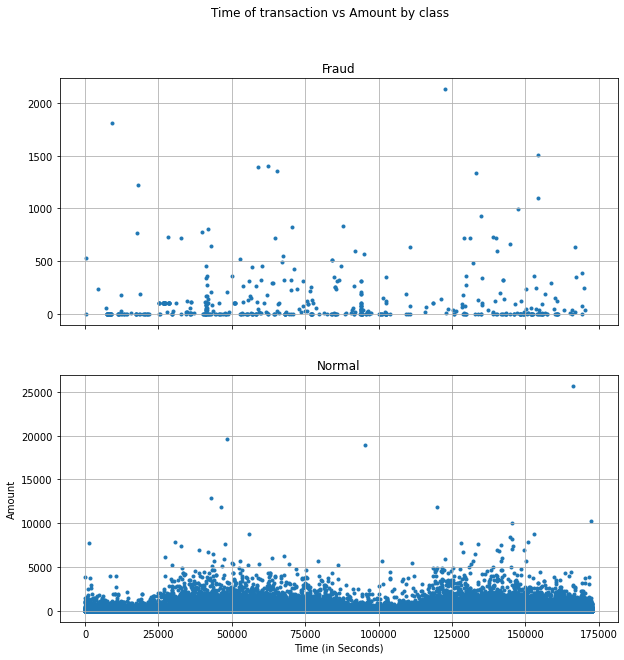

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,10))
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(fraud.Time, fraud.Amount, marker='.')
ax1.set_title('Fraud')
ax1.grid()
ax2.scatter(normal.Time, normal.Amount, marker='.')
ax2.set_title('Normal')
ax2.grid()
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

Data Modeling

In [ ]:
data = df.drop(['Time'], axis =1)

In [ ]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train
X_test = X_test
print(X_train.shape)

print(X_test.shape)
print(y_test.shape)

(227451, 29)
(56962, 29)
(56962,)


In [ ]:
scaler = StandardScaler().fit(X_train.Amount.values.reshape(-1,1))
X_train['Amount'] = scaler.transform(X_train.Amount.values.reshape(-1,1))
X_test['Amount'] = scaler.transform(X_test.Amount.values.reshape(-1,1))

In [ ]:
X_train.shape

(227451, 29)

Model Training:


In [ ]:
from keras.layers import Input, Dense
from keras import regularizers
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, TensorBoard

In [ ]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [ ]:
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [ ]:
X_train.shape

(227451, 29)

In [ ]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    )

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.3,
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
4976/4976 [==============================] - 9s 2ms/step - loss: 0.8887 - val_loss: 0.8145
Epoch 2/100
4976/4976 [==============================] - 7s 1ms/step - loss: 0.7426 - val_loss: 0.7822
Epoch 3/100
4976/4976 [==============================] - 8s 2ms/step - loss: 0.7275 - val_loss: 0.7663
Epoch 4/100
4976/4976 [==============================] - 7s 2ms/step - loss: 0.7267 - val_loss: 0.7596
Epoch 5/100
4976/4976 [==============================] - 7s 1ms/step - loss: 0.7083 - val_loss: 0.7566
Epoch 6/100
4976/4976 [==============================] - 8s 2ms/step - loss: 0.7132 - val_loss: 0.7550
Epoch 7/100
4976/4976 [==============================] - 7s 1ms/step - loss: 0.6931 - val_loss: 0.7520
Epoch 8/100
4976/4976 [==============================] - 7s 1ms/step - loss: 0.7068 - val_loss: 0.7493
Epoch 9/100
4976/4976 [==============================] - 7s 2ms/step - loss: 0.7081 - val_loss: 0.7460
Epoch 10/100
4976/4976 [==============================] - 7s 1ms/step - l

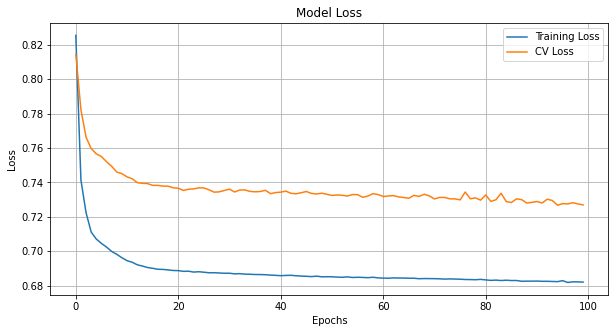

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(history['loss'], label = 'Training Loss')
plt.plot(history['val_loss'], label = 'CV Loss')
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [ ]:
autoencoder = load_model('model.h5')

Model Evaluation:

In [ ]:
predictions = autoencoder.predict(X_test)

In [ ]:
predictions.shape

(56962, 29)

In [ ]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class':y_test})

In [ ]:
error_df.groupby(['true_class']).describe()

reconstruction_error            ...                       
                          count      mean  ...        75%         max
true_class                                 ...                       
0                       56864.0   0.67650  ...   0.601428  156.453586
1                          98.0  30.37552  ...  49.847986  264.211300

[2 rows x 8 columns]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


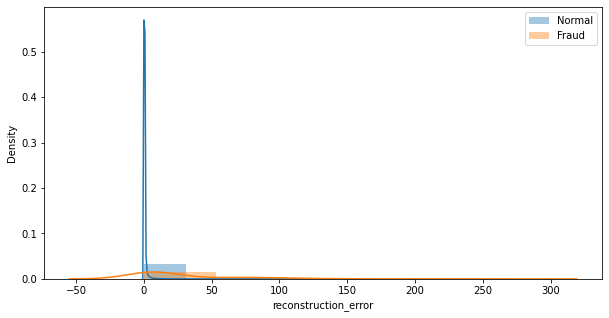

In [ ]:
plt.figure(figsize = (10,5))
sns.distplot(error_df[error_df['true_class']==0]['reconstruction_error'], bins = 5, label = 'Normal')
sns.distplot(error_df[error_df['true_class']==1]['reconstruction_error'], bins=5, label = 'Fraud')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support, roc_auc_score)

In [ ]:
threshold = 1.4

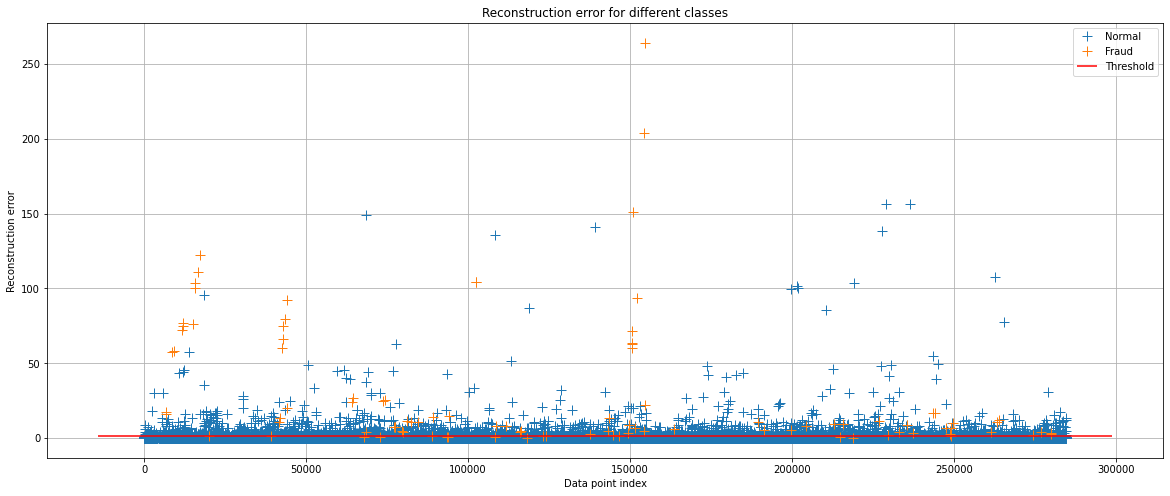

In [ ]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots(figsize = (20,8))

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='+', ms=10, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.grid()
plt.show();

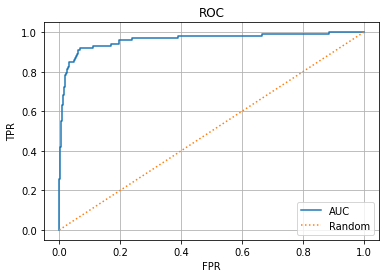

In [ ]:
fpr, tpr, thres = roc_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(fpr, tpr, label = 'AUC') 
plt.plot([0,1], [0,1], ':', label = 'Random') 
plt.legend() 
plt.grid() 
plt.ylabel("TPR") 
plt.xlabel("FPR") 
plt.title('ROC') 
plt.show() 

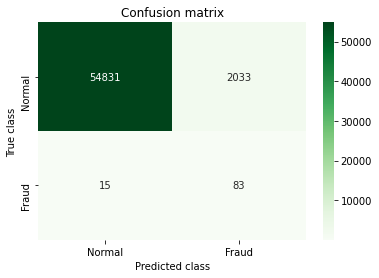

In [ ]:
LABELS = ['Normal', 'Fraud']
threshold = 2
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", cmap='Greens');
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
## Chosen metric is AUC ROC as data is imbalanced
print("Area under ROC : ", roc_auc_score(error_df.true_class,y_pred ))

Area under ROC :  0.9055934029492496


In [ ]:
print(classification_report(error_df.true_class,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.85      0.07        98

    accuracy                           0.96     56962
   macro avg       0.52      0.91      0.53     56962
weighted avg       1.00      0.96      0.98     56962

